In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bagsolver.bag import Bag
from bagsolver.utils import load_bag_data, parse_solution
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
import subprocess

def gen_instances(I, N, n=24, W=3000, C=3000, w="bal", m=0.8, c="uni") -> tuple:
    args = f"-I {I} -N {N} -n {n} -W {W} -C {C} -w {w} -m {m} -c {c}"
    full = f"./data/GEN/kg2 {args}"
    popen = subprocess.Popen(full.split(" "), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, errors = popen.communicate()
    return args, output.decode().strip()

In [130]:
args, instances = gen_instances(1, 10)

In [176]:
import random

def permute_instance(instance):
    iid, count, capacity, *items = instance.split(" ")
    pairs = list(zip(items[::2], items[1::2]))
    random.shuffle(pairs)
    return " ".join([iid, count, capacity] + list(sum(pairs, ())))

In [192]:
# Bound methods of the Bag class
algorithms = ["solve_bruteforce", "solve_branch_bound", "solve_greedy", "solve_dynamic_cost"]

### Generate robust

In [249]:
iid = 1  # starting instance id
N = 500  # number of generated items
n = 20   # instance size

records = []

# weight distribution - default bal
args, result = gen_instances(iid, N, n=n)
for inst in result.split("\n"):
    for alg in algorithms:
        for i in range(10):
            perminst = permute_instance(inst)
            records.append([perminst, alg, args])

tasks = pd.DataFrame(records, columns=["instance", "method", "args"])
tasks.to_csv("hw3_tasks_robust.csv", index=False)

##### Robust Viz

In [320]:
df = pd.read_csv("hw3_output_robust.csv")

In [321]:
df["id"] = df.instance.apply(lambda x: x.split(" ")[0])

In [322]:
var = df.groupby(by=["method", "id"]).agg(["mean", "var"])

In [340]:
mvar = var.reset_index()[[("method",''), ("elapsed", "var"), ("elapsed", "mean")]]

In [341]:
mvar.columns = ["method", "var", "mean"]

In [342]:
mean_var = mvar.groupby("method").mean()

In [346]:
mean_var["var"] / mean_var["mean"]

method
solve_branch_bound   0.00282743
solve_bruteforce     0.21221585
solve_dynamic_cost   0.04842127
solve_greedy         0.00015563
dtype: float64

In [330]:
print(mean_var.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    elapsed &       mean \\
method             &            &            \\
\midrule
solve\_branch\_bound & 0.00001817 & 0.00642724 \\
solve\_bruteforce   & 1.95676123 & 9.22061772 \\
solve\_dynamic\_cost & 0.01843123 & 0.38064328 \\
solve\_greedy       & 0.00000001 & 0.00006964 \\
\bottomrule
\end{tabular}



### Generate pilot

In [ ]:
# the ratio of max knapsack capacity to total weight
for m in np.linspace(0, 2, 5):
    # cost distribution/style - default uni
    for c in ["uni", "corr", "strong"]:

In [459]:
iid = 1  # starting instance id
N = 10   # number of generated items
n = 20   # instance size

records = []

# weight distribution - default bal
for w in ["bal", "light", "heavy"]:
    args, result = gen_instances(iid, N, n=n, w=w)
    for inst in result.split("\n"):
        for alg in algorithms:
            records.append([inst, alg, args, "w"])
    iid += N
    
for m in np.linspace(0, 2, 5):
    args, result = gen_instances(iid, N, n=n, m=m)
    for inst in result.split("\n"):
        for alg in algorithms:
            records.append([inst, alg, args, "m"])
    iid += N

for c in ["uni", "corr", "strong"]:
    args, result = gen_instances(iid, N, n=n, c=c)
    for inst in result.split("\n"):
        for alg in algorithms:
            records.append([inst, alg, args, "c"])
    iid += N

tasks = pd.DataFrame(records, columns=["instance", "method", "args", "tag"])
tasks.to_csv("hw3_tasks_pilot.csv", index=False)

### Prepare data for pilot

In [462]:
def args2dict(args) -> dict:
    return {tup.split(" ")[0]: tup.split(" ")[1] for tup in args.strip("-").split("-")}

In [463]:
df = pd.read_csv("hw3_output_pilot.csv")
df.args = df.args.apply(args2dict)
df = df.join(pd.json_normalize(df.args)).drop(columns=["args"])

In [464]:
df.m = df.m.astype(float)
df.w = df.w.map({"light": 0, "bal": 1, "heavy": 2})
df.c = df.c.map({"uni": 0, "corr": 1, "strong": 2})

In [465]:
def plot_corr(method):
    sub = df[df.method==method].copy()
    fact = sub[["w", "m", "c", "elapsed"]] #.apply(lambda x: pd.factorize(x)[0])
    corr = fact.corr(method="pearson", min_periods=1)
    return corr["elapsed"]

In [466]:
results = []
for method in df.method.unique():
    c = plot_corr(method)
    results.append([method, c["w"], c["m"], c["c"]])

In [467]:
res = pd.DataFrame(results, columns=["method", "w", "m", "c"])
corr = res.set_index("method").abs()

In [468]:
corr = corr.rename(
    columns={
        "w": "w_dist",   # weight distribution
        "m": "cw_ratio", # ratio of max knapsack capacity to total weight
        "c": "pw_corr",  # cost distribution/style - default uni
    }
)

In [469]:
corr = corr.loc[["solve_bruteforce", "solve_greedy", "solve_branch_bound", "solve_dynamic_cost"]]

corr.index = corr.index.map({
    "solve_bruteforce": "bruteforce",
    "solve_greedy": "heuristic",
    "solve_branch_bound":"branch&bound",
    "solve_dynamic_cost": "dynamic"
})

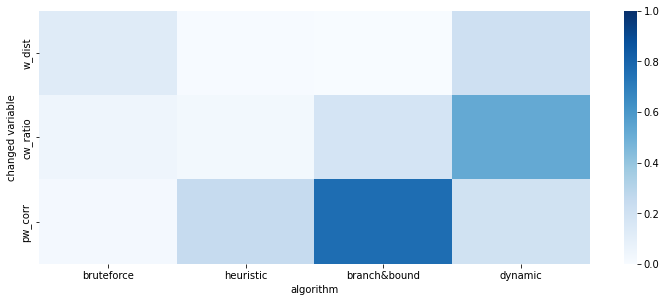

In [470]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(corr.T, vmin=0, vmax=1, cmap="Blues")
ax.set_xlabel("algorithm")
ax.set_ylabel("changed variable")
plt.tight_layout(pad=0)
plt.savefig('report3/images/pilot.png', bbox_inches='tight')
plt.show()

### Detailed Experiments

In [439]:
ns = [4, 8, 16, 20, 24]
iid = 1   # starting instance id
N = 100   # number of generated items
records = []

In [ ]:
for n in ns:
    for alg in ["solve_branch_bound", "solve_dynamic_cost"]:
        for w in ["bal", "light", "heavy"]:
            args, result = gen_instances(iid, N, n=n, w=w)
            for inst in result.split("\n"):
                for alg in algorithms:
                    records.append([inst, alg, args, "w"])
            iid += N
        for m in np.linspace(0, 2, 5):
            args, result = gen_instances(iid, N, n=n, m=m)
            for inst in result.split("\n"):
                for alg in algorithms:
                    records.append([inst, alg, args, "m"])
            iid += N
        for c in ["uni", "corr", "strong"]:
            args, result = gen_instances(iid, N, n=n, c=c)
            for inst in result.split("\n"):
                for alg in algorithms:
                    records.append([inst, alg, args, "c"])
            iid += N
            
tasks = pd.DataFrame(records, columns=["instance", "method", "args", "tag"])
tasks.to_csv("hw3_tasks_pilot.csv", index=False)

In [ ]:
n = 20   # instance size


# weight distribution - default bal
for w in ["bal", "light", "heavy"]:
    # the ratio of max knapsack capacity to total weight
    for m in np.linspace(0, 2, 5):
        # cost distribution/style - default uni
        for c in ["uni", "corr", "strong"]:
            args, result = gen_instances(iid, N, n=n, w=w, m=m, c=c)
            for inst in result.split("\n"):
                for alg in algorithms:
                    records.append([inst, alg, args])
            iid += N

tasks = pd.DataFrame(records, columns=["instance", "method", "args"])
tasks.to_csv("hw3_tasks_pilot.csv", index=False)